# 2 Data wrangling

## 2.2 Introduction

This step focuses on collecting your data, organizing it, and making sure it's well defined.

### 2.2.1 Recap Of Data Science Problem

The purpose of this data science project is to predict time to failure given each small segment of acoustic signal using a data-driven model

## 2.3 Imports

In [211]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from pandas_profiling import ProfileReport
import numpy as np
import glob, os
pd.set_option("display.precision", 8)
pd.options.display.max_rows = 99
from scipy import signal
from scipy.stats import kurtosis, skew
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import datetime
%matplotlib inline  

## 2.4 Objectives

There are some fundamental questions to resolve in this notebook before you move on.

* Do you think you may have the data you need to tackle the desired question?
    * Have you identified the required target value?
    * Do you have potentially useful features?
* Do you have any fundamental issues with the data?
* Do your column names correspond to what those columns store?
    * Check the data types of your columns. Are they sensible?
    * Calculate summary statistics for each of your columns, such as mean, median, mode, standard deviation, range, and number of unique values. What does this tell you about your data? What do you now need to investigate?

# 2.5 Load the training data

In [7]:
filename = 'D:/DataScience/rawdata/2ndCapstone/train.csv'

## 2.5.1 Check a small section of data

In [8]:
# df_tr_sec =  pd.read_csv(filename,nrows = 6e6)
records = 150_000
df_tr_sec =  pd.read_csv(filename,nrows = records)


Wall time: 162 ms


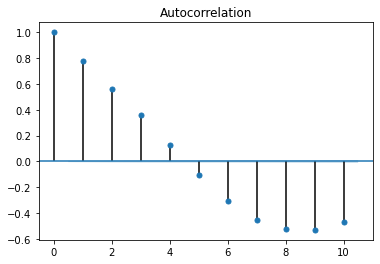

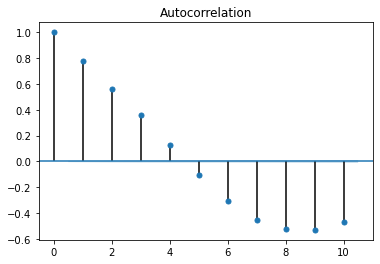

In [382]:
plot_acf(df_tr_sec['acoustic_data'], lags=10,alpha=.05, fft = True)

In [4]:
df_tr_sec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 2 columns):
 #   Column           Dtype  
---  ------           -----  
 0   acoustic_data    int64  
 1   time_to_failure  float64
dtypes: float64(1), int64(1)
memory usage: 152.6 MB


In [5]:
df_tr_sec.describe()

,acoustic_data,time_to_failure
count,1.00000000e+07,1.00000000e+07
mean,4.50207230e+00,5.18359786e+00
std,1.78070725e+01,5.09128587e+00
min,-4.62100000e+03,7.95479823e-04
25%,2.00000000e+00,6.49897065e-01
50%,4.00000000e+00,1.29889865e+00
75%,7.00000000e+00,1.08916984e+01
max,3.25200000e+03,1.15408000e+01


In [6]:
df_tr_sec.head()

,acoustic_data,time_to_failure
0,12,1.46909998
1,6,1.46909998
2,8,1.46909998
3,5,1.46909998
4,8,1.46909998


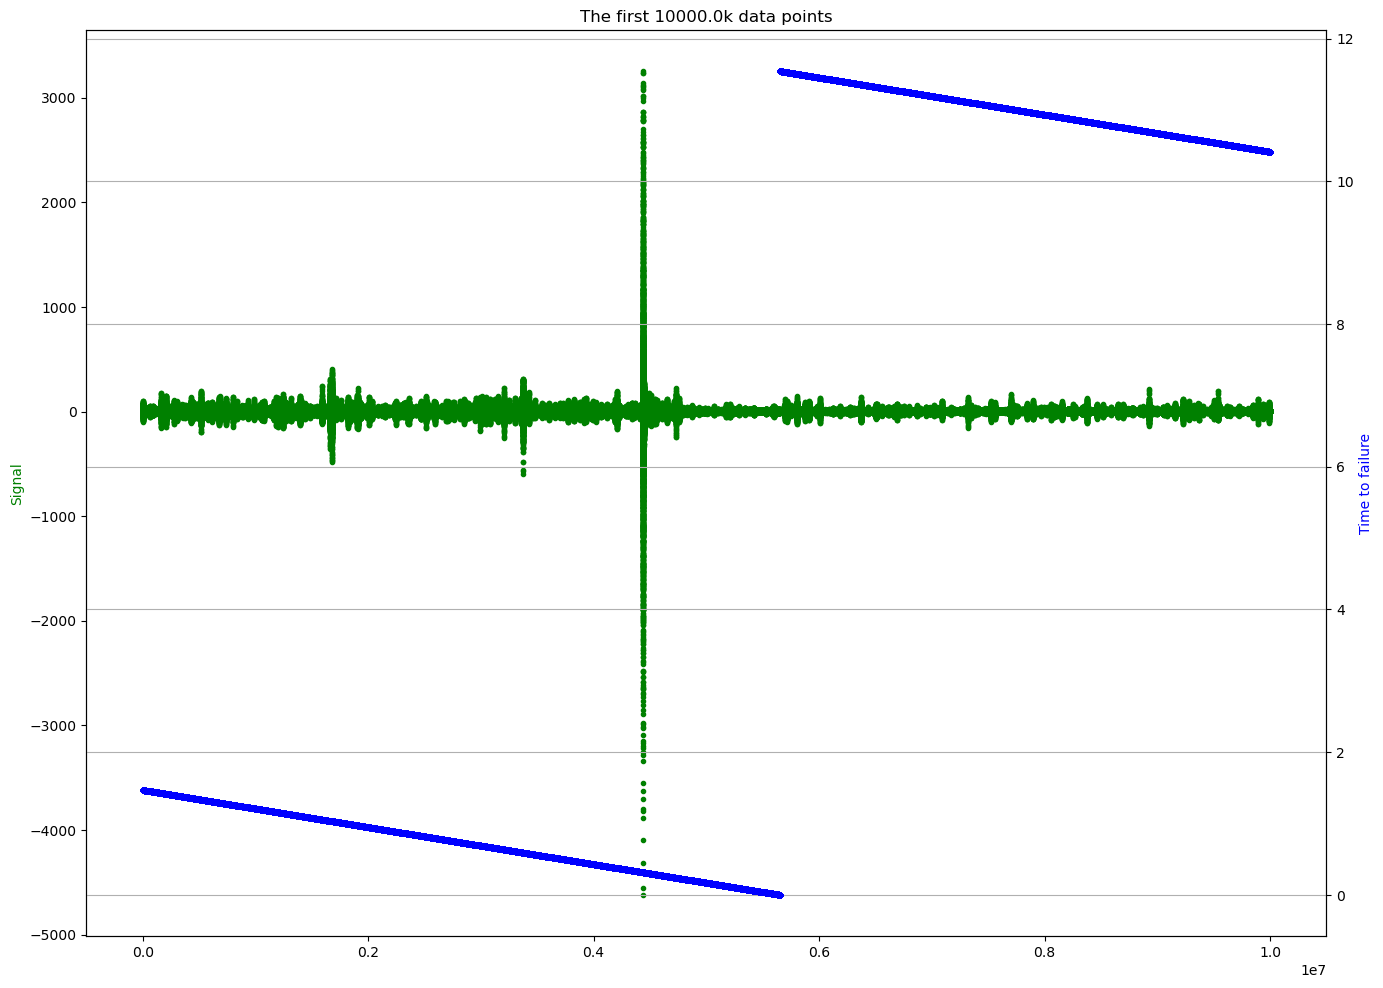

In [7]:
fig, ax1 = plt.subplots(1,1,figsize=(16, 12), dpi=100 )
ax2 = ax1.twinx()
ax1.plot(df_tr_sec['acoustic_data'], 'g.')
ax2.plot(df_tr_sec['time_to_failure'], 'b.')


ax1.set_ylabel('Signal', color='g')
ax2.set_ylabel('Time to failure', color='b')
ax2.grid()
plt.title(f'The first {records /1000}k data points');

 1.00000008e-09    3725583
 1.09999998e-09    2328159
 1.10000009e-09    1412528
 1.09999987e-09     740217
 1.10000001e-09     439464
 2.00000017e-09     394273
 1.10000004e-09     346849
 9.99998306e-10     182015
 1.10000000e-09     132720
 1.09999999e-09     126342
 1.99999839e-09      40494
 1.10100000e-09      34823
 1.09900000e-09      25141
 1.10000000e-09      11186
 1.10000000e-09       9539
 1.10000000e-09       9138
 1.09900000e-09       4579
 1.09900000e-09       4072
 1.10010000e-09       3521
 1.10050000e-09       2850
 1.09960000e-09       2497
 1.09899999e-09       2369
 1.10010000e-09       1915
 1.09900000e-09       1749
 1.09960000e-09       1249
 1.09960000e-09       1199
 1.10003000e-09       1184
 1.10100000e-09        952
 1.10100001e-09        948
 1.09950000e-09        835
 1.10010000e-09        806
 1.10010000e-09        719
 1.09549550e-03        700
 1.10100000e-09        658
 1.10004000e-09        606
 1.09958000e-09        553
 1.10100001e-09        533
 

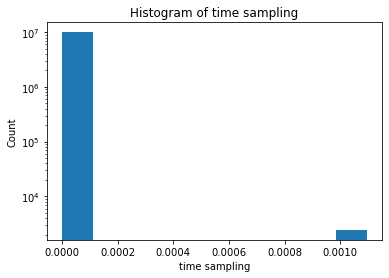

In [8]:
# time2fail_np = df_tr_sec['time_to_failure'].values
# # dt_np = time2fail_np[0:-1] - time2fail_np[1:] 
dt = pd.Series(-df_tr_sec['time_to_failure'].diff(), name='dt')
print(dt.value_counts())
plt.hist(dt.sort_values()[1:])# remove the time difference between two segement, which is about -11
plt.title('Histogram of time sampling')
plt.ylabel('Count')
plt.yscale('log')
plt.xlabel('time sampling');

del df_tr_sec

`acoustic_data` distribute unevenly.

From `time_to_failure`, the equipment may work a while to acquire signal at high frequency (1.1e-9 s), and then take a rest (1e-3 s)before next aquisition.

The sampling rate is not a constant, and the distribution of time step is bimodal with one large timestep and a small timestep.

Try resample with the large timestep later.



## 2.5.2 Load the complete training data

In [3]:
%%time
train_df = pd.read_csv(filename, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

Wall time: 4min 29s


## 2.5.3 Check complete data every 100 records

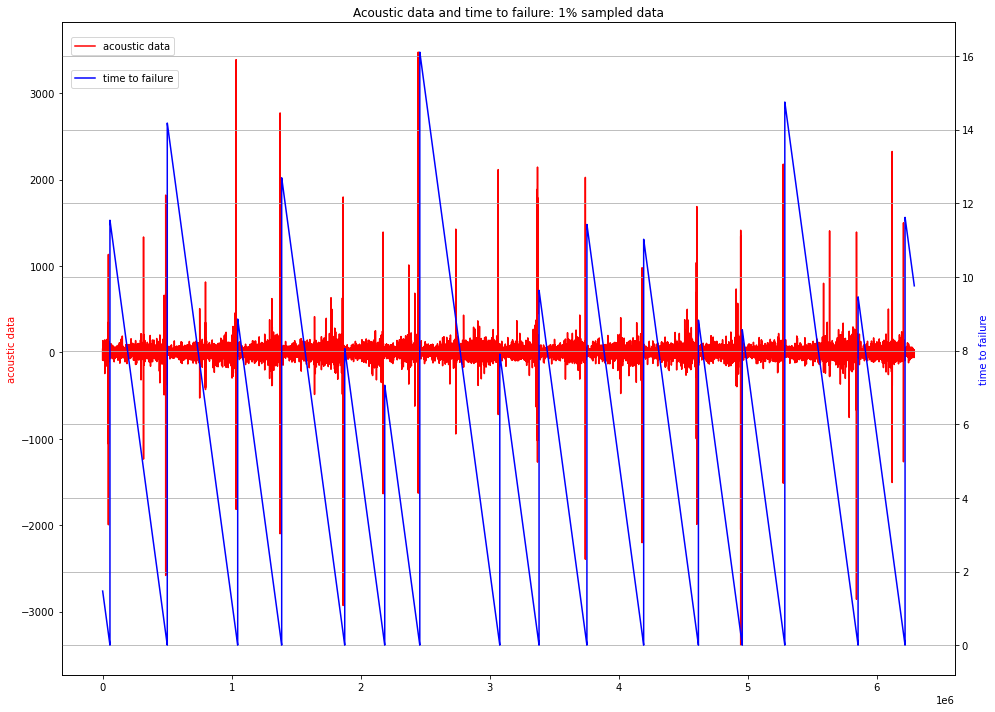

In [10]:
train_ad_sample_df = train_df['acoustic_data'].values[::100]
train_ttf_sample_df = train_df['time_to_failure'].values[::100]

def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(16, 12))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

# 2.6 Load the testing data

In [11]:
testfilepath = "../raw_data/test/"
os.chdir(testfilepath)
testfiles = glob.glob("*.csv")
print(testfiles[0:5])

['seg_00030f.csv', 'seg_0012b5.csv', 'seg_00184e.csv', 'seg_003339.csv', 'seg_0042cc.csv']


In [12]:
def plot_test_file(fileobject):
    df = pd.read_csv(fileobject)
    print(df.describe())
    df.plot(y = 'acoustic_data')
    plt.title(fileobject[0:-4])

In [13]:
df_te = pd.read_csv(testfiles[0])
df_te.head()

,acoustic_data
0,4
1,0
2,-2
3,0
4,2


14
         acoustic_data
count  150000.00000000
mean        4.49178000
std         4.89368969
min       -75.00000000
25%         2.00000000
50%         4.00000000
75%         7.00000000
max       115.00000000
14
         acoustic_data
count  150000.00000000
mean        4.17115333
std         5.92283944
min      -140.00000000
25%         2.00000000
50%         4.00000000
75%         7.00000000
max       152.00000000
14
         acoustic_data
count  150000.00000000
mean        4.61026000
std         6.94699008
min      -193.00000000
25%         2.00000000
50%         5.00000000
75%         7.00000000
max       248.00000000


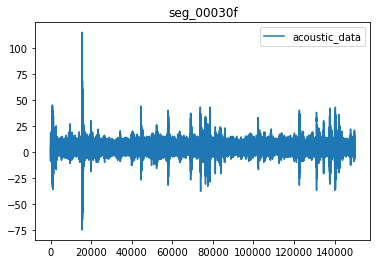

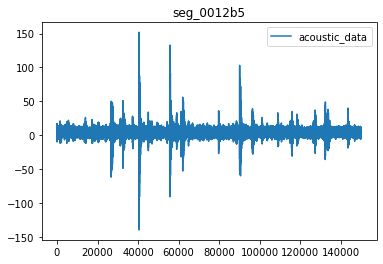

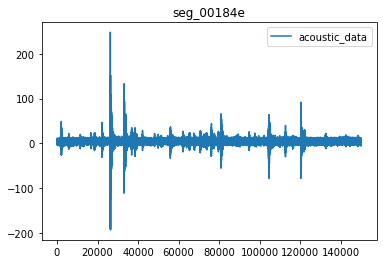

In [14]:
for testfile in testfiles[0:3]:
    print(len(testfile))
    plot_test_file(testfile)
    

In [ ]:
def plot_test_file_freq(fileobject):
    df = pd.read_csv(fileobject)
    print(df.describe())
    sp = np.fft.fft(df.values)
    plt.title(fileobject[0:-4])

## 2.7 Rolling window to get statistic features

In [18]:
seg_len = 150_000
list0 = ["segid", "ttf_avg"]

### 2.7.1 Rolling statistics features in time domain

In [19]:
# statistic feature_name in time_domain
stat_funcs = ["mean","med","std","kurt","skew", "min","max","mode","qt25","qt75","iqr","abs_sum"]


In [65]:
# lag autocorr feature
lag_funcs = ["ac" + str(i) for i in range(1,11)]
lag_funcs

['ac1', 'ac2', 'ac3', 'ac4', 'ac5', 'ac6', 'ac7', 'ac8', 'ac9', 'ac10']

In [66]:
# list0 = ["segid", "ttf_avg"]
# list1 = ["rol" + w + "_" +fun for w in ["50", "500", "5000"] for fun in ["mean","med","std","kurt","skew"]]
# list2 = [x + "_std" for x in list1]
# list3 = ["rol" + w  + "_Refft"  for w in ["50", "500", "5000"] ]
# list4 = ["rol" + w  + "_Imfft"  for w in ["50", "500", "5000"] ]
# list5 = [x + "_med" for x in list3]
# list6 = [x + "_std" for x in list3]
# list7 = [x + "_kurt" for x in list3]
# list8 = [x + "_skew" for x in list3]
# list9 = [x + "_med" for x in list4]
# list10 = [x + "_std" for x in list4]
# list11 = [x + "_kurt" for x in list4]
# list12 = [x + "_skew" for x in list4]

# keys_list = list0 + list1 + list2 + list3 + list4 + list5 + list6 + list7 + list8 + list9 + list10 + list11 + list12

keys_list = list0 + stat_funcs + keys_rol + lag_funcs
print(len(keys_list))

train_transform_dict = dict()

for k in keys_list:
    train_transform_dict[k] = []
# print(train_transform_dict)

124
{'segid': [], 'ttf_avg': [], 'mean': [], 'med': [], 'std': [], 'kurt': [], 'skew': [], 'min': [], 'max': [], 'mode': [], 'qt25': [], 'qt75': [], 'iqr': [], 'abs_sum': [], 'rol50_mean_med': [], 'rol50_mean_std': [], 'rol50_mean_kurt': [], 'rol50_mean_skew': [], 'rol50_med_med': [], 'rol50_med_std': [], 'rol50_med_kurt': [], 'rol50_med_skew': [], 'rol50_std_med': [], 'rol50_std_std': [], 'rol50_std_kurt': [], 'rol50_std_skew': [], 'rol50_kurt_med': [], 'rol50_kurt_std': [], 'rol50_kurt_kurt': [], 'rol50_kurt_skew': [], 'rol50_skew_med': [], 'rol50_skew_std': [], 'rol50_skew_kurt': [], 'rol50_skew_skew': [], 'rol100_mean_med': [], 'rol100_mean_std': [], 'rol100_mean_kurt': [], 'rol100_mean_skew': [], 'rol100_med_med': [], 'rol100_med_std': [], 'rol100_med_kurt': [], 'rol100_med_skew': [], 'rol100_std_med': [], 'rol100_std_std': [], 'rol100_std_kurt': [], 'rol100_std_skew': [], 'rol100_kurt_med': [], 'rol100_kurt_std': [], 'rol100_kurt_kurt': [], 'rol100_kurt_skew': [], 'rol100_skew_me

In [148]:
qt25 = lambda x: x.quantile(0.25)
qt75 = lambda x: x.quantile(0.75)
iqr = lambda x : qt75(x) - qt25(x)
abs_sum = lambda x : sum(abs(x))
statistics_names = ["mean","median","std","kurt","skew","min","max","qt25","qt75","iqr","abs_sum"]
def chunk_statistics(chunk):
    temp_df = chunk['acoustic_data'].agg(["mean","median","std","kurt","skew","min","max",qt25,qt75,iqr,abs_sum])
    return pd.DataFrame(temp_df.values.reshape(1,len(statistics_names) ), columns = statistics_names)

In [212]:
# rolling statistic feature in time_domain
# abs_sum = lambda x: sum(abs(x))
rol_funcs = ["mean","median","std","kurt","skew"]
rol_funcs_names = ["mean","median","std","kurt","skew"]
windows = [50, 100,500,1000, 5000]


In [213]:
# rol_features
def rolling_statistics(chunk):
    rtn_df = []

    for w in windows:
        temp_rolling = chunk['acoustic_data'].rolling(w, center = True)
        temp_df = temp_rolling.agg(rol_funcs).agg(["mean","median","std","kurt","skew"])
        window_df = pd.DataFrame(temp_df.values.reshape((1,len(temp_df.columns) * len(temp_df))), 
                     columns = ["rol" + str(w) + "_" + func1 + "_"+ func2 \
                                for func2 in ["smean","smedian","sstd","skurt","sskew"] for func1 in rol_funcs_names ])
        if len(rtn_df) > 0:
            rtn_df = pd.concat([rtn_df, window_df], axis=1)
        else:
            rtn_df = window_df
    return rtn_df      
    


In [336]:
rol_feature_names = ["rol" + str(w) + "_" + func1 + "_"+ func2 \
                     for w in windows\
                     for func1 in rol_funcs_names \
                     for func2 in ["smean","smedian","sstd","skurt","sskew"] \
                     ]
print(rol_feature_names)

['rol50_mean_smean', 'rol50_mean_smedian', 'rol50_mean_sstd', 'rol50_mean_skurt', 'rol50_mean_sskew', 'rol50_median_smean', 'rol50_median_smedian', 'rol50_median_sstd', 'rol50_median_skurt', 'rol50_median_sskew', 'rol50_std_smean', 'rol50_std_smedian', 'rol50_std_sstd', 'rol50_std_skurt', 'rol50_std_sskew', 'rol50_kurt_smean', 'rol50_kurt_smedian', 'rol50_kurt_sstd', 'rol50_kurt_skurt', 'rol50_kurt_sskew', 'rol50_skew_smean', 'rol50_skew_smedian', 'rol50_skew_sstd', 'rol50_skew_skurt', 'rol50_skew_sskew', 'rol100_mean_smean', 'rol100_mean_smedian', 'rol100_mean_sstd', 'rol100_mean_skurt', 'rol100_mean_sskew', 'rol100_median_smean', 'rol100_median_smedian', 'rol100_median_sstd', 'rol100_median_skurt', 'rol100_median_sskew', 'rol100_std_smean', 'rol100_std_smedian', 'rol100_std_sstd', 'rol100_std_skurt', 'rol100_std_sskew', 'rol100_kurt_smean', 'rol100_kurt_smedian', 'rol100_kurt_sstd', 'rol100_kurt_skurt', 'rol100_kurt_sskew', 'rol100_skew_smean', 'rol100_skew_smedian', 'rol100_skew_sst

In [326]:
lag_names = ["lag" + str(i) for i in range(1,11)]
def ac_features(chunk):
    
    temp = acf(chunk['acoustic_data'], nlags=10, fft = True)
    return pd.DataFrame(temp[1:].reshape(1,10), columns = lag_names)

In [215]:
""" statistic feature in time_domain"""
def generate_stats(chunk, ttf_list):
    if chunk.iloc[-1,1] < chunk.iloc[0,1]:
        ttf_list.append(chunk["time_to_failure"].mean())
        rol_stats_df = rolling_statistics(chunk)
        stats_df = chunk_statistics(chunk)
        ac_df = ac_features(chunk)
        tfeature_list = pd.concat([stats_df, rol_stats_df,ac_df], axis = 1).values.tolist()[0] # rol_stats_df
        return ttf_list, tfeature_list
    else:
        return ttf_list, None

In [216]:
# %%time
j = -1
        
ttf_list = []  
final = []
for chunk in pd.read_csv(filename, chunksize = seg_len, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32}): 
    j += 1
    if j % 500 == 0:
        print(j)
        now = datetime.datetime.now()
        print(now)
    
    firsthalf_chunk = chunk.iloc[0:int(len(chunk)/2)]
    if j > 0:
        combined_chunk = pd.concat([ lasthalf_chunk, firsthalf_chunk], axis = 0)
        ttf_list, tfeature_list = generate_stats(combined_chunk, ttf_list)
        if tfeature_list is not None:
            final.append( tfeature_list)
 
    lasthalf_chunk = chunk.iloc[int(len(chunk)/2):]
    ttf_list, all_stats = generate_stats(chunk, ttf_list)
    
    if tfeature_list is not None:
        final.append( tfeature_list)
#     if j > 1:
#         break
pd.DataFrame(final, index = ttf_list).to_csv('../data/train_features_timedomain.csv')
         


0
2022-09-04 09:38:42.772681
50
2022-09-04 09:41:47.722516
100
2022-09-04 09:44:10.219048
150
2022-09-04 09:46:28.479060
200
2022-09-04 09:48:58.991954
250
2022-09-04 09:51:29.462417
300
2022-09-04 09:53:47.482564
350
2022-09-04 09:56:14.805515
400
2022-09-04 09:58:28.287685
450
2022-09-04 10:00:53.297976
500
2022-09-04 10:03:04.539989
550
2022-09-04 10:05:21.932857
600
2022-09-04 10:07:30.688586
650
2022-09-04 10:09:40.220150
700
2022-09-04 10:11:46.056178
750
2022-09-04 10:13:56.931124
800
2022-09-04 10:16:07.273714
850
2022-09-04 10:18:19.352231
900
2022-09-04 10:20:43.127010
950
2022-09-04 10:23:05.286998
1000
2022-09-04 10:25:27.253091
1050
2022-09-04 10:27:40.141119
1100
2022-09-04 10:30:14.367747
1150
2022-09-04 10:32:26.242507
1200
2022-09-04 10:34:39.939585
1250
2022-09-04 10:36:54.430017
1300
2022-09-04 10:39:12.252261
1350
2022-09-04 10:41:32.430419
1400
2022-09-04 10:43:45.774046
1450
2022-09-04 10:45:59.212832
1500
2022-09-04 10:48:13.873924
1550
2022-09-04 10:50:26.883118

In [337]:
tfeature_names = statistics_names + rol_feature_names + lag_names

In [376]:
# tfeatures_df = pd.DataFrame(final, columns = tfeature_names, index = ttf_list).reset_index()
tfeatures_df = pd.read_csv('../data/train_features_timedomain.csv', index_col = 0)
tfeatures_df.columns = tfeature_names
tfeatures_df.drop(tfeatures_df.tail(1).index,inplace=True)
tfeatures_df.shape
# tfeatures_df.head()

(8356, 146)

In [341]:
tfeatures_df.isnull().sum().sort_values(ascending = False)

mean                    0
rol1000_skew_skurt      0
rol1000_median_sstd     0
rol1000_median_skurt    0
rol1000_median_sskew    0
                       ..
rol100_std_skurt        0
rol100_std_sskew        0
rol100_kurt_smean       0
rol100_kurt_smedian     0
lag10                   0
Length: 146, dtype: int64

In [377]:
tfeatures_df.reset_index(inplace = True)
tfeatures_df.rename(columns = {'index':'ttf_avg'}, inplace = True)
tfeatures_df.head()

,ttf_avg,mean,median,std,kurt,skew,min,max,qt25,qt75,...,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10
0,1.45006776,4.88411333,5.0,5.10110613,33.66248129,-0.02406117,-98.0,104.0,3.0,7.0,...,0.77841318,0.55944206,0.35973793,0.12522164,-0.10440600,-0.30418905,-0.44937161,-0.52532767,-0.52961242,-0.46966076
1,1.43078184,4.74680000,5.0,6.17338350,116.79737733,0.52628358,-154.0,181.0,2.0,7.0,...,0.83242757,0.63679191,0.43307734,0.19442753,-0.04214953,-0.24693865,-0.39586686,-0.47387386,-0.47816951,-0.41722502
2,1.41123080,4.72576667,5.0,6.58882378,98.75851718,0.39056050,-154.0,181.0,2.0,7.0,...,0.84441693,0.64999067,0.43727813,0.18782032,-0.06099321,-0.27633527,-0.43246331,-0.51446970,-0.51696729,-0.45033681
3,1.39201939,4.75300000,5.0,5.71503591,33.74477916,-0.10766378,-115.0,111.0,2.0,7.0,...,0.80793305,0.59365371,0.37652187,0.12154257,-0.13047946,-0.34737090,-0.50070188,-0.57646809,-0.56984888,-0.49074470
4,1.37191772,4.90639333,5.0,6.96739703,33.55521141,0.21739056,-106.0,140.0,2.0,7.0,...,0.85474671,0.66447936,0.44964351,0.19596957,-0.05793300,-0.27988248,-0.44228698,-0.53061538,-0.54123783,-0.48012031


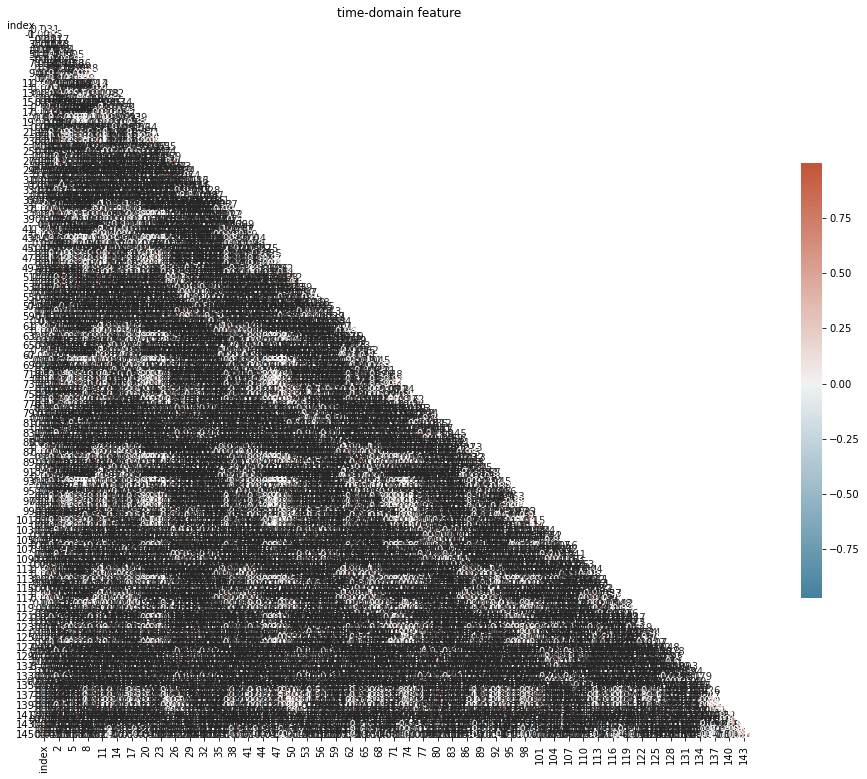

In [221]:
corr_lag = tfeatures_df.corr()
mask = np.triu(np.ones_like(corr_lag, dtype=bool))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(16, 16))
ax = sns.heatmap(corr_lag, mask=mask, cmap=cmap,  center=0,
                 square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
ax.set_title('time-domain feature');

### 2.7.2 Features in Frequency domain

In [314]:
freq_stat_names = ["mean","median","std","kurt","skew","min","max","qt25","qt75","iqr","abs_sum"]
freq_feature_names = ["fft_real_" + fsn for fsn in freq_stat_names] + ["fft_imag_" + fsn for fsn in freq_stat_names]

def chunk_statistics(chunk):
    sp = np.fft.fft(chunk['acoustic_data'])
    sp_real_df = pd.Series(sp.real)
    sp_imag_df = pd.Series(sp.imag)
    real_df = sp_real_df.agg(["mean","median","std","kurt","skew","min","max",qt25,qt75,iqr,abs_sum])
    imag_df = sp_imag_df.agg(["mean","median","std","kurt","skew","min","max",qt25,qt75,iqr,abs_sum])
    np1 = real_df.values.reshape(1,len(freq_stat_names) )
    np2 = imag_df.values.reshape(1,len(freq_stat_names) )
    freq_feature_list = np.hstack([np1, np2]).tolist()[0]
    return freq_feature_list

In [315]:
""" statistic feature in freq_domain"""
def generate_freq_feature(chunk):
    if (chunk.iloc[-1,1] < chunk.iloc[0,1]) :
#         ttf_list.append(chunk["time_to_failure"].mean())
        freq_feature_list = chunk_statistics(chunk)
        return freq_feature_list
    else:
        return None

In [317]:
%%time
j = -1
f_features = []
for chunk in pd.read_csv(filename, chunksize = seg_len, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32}):   
    j += 1
#     print(j)
    if j % 500 == 0:
        print(j)
        now = datetime.datetime.now()
        print(now)
    
    firsthalf_chunk = chunk.iloc[0:int(len(chunk)/2)]
    if j > 0:
        combined_chunk = pd.concat([ lasthalf_chunk, firsthalf_chunk], axis = 0)
        freq_feature_list = generate_freq_feature(combined_chunk)
        if freq_feature_list is not None:
            f_features.append( freq_feature_list)
    lasthalf_chunk = chunk.iloc[int(len(chunk)/2):]
    freq_feature_list = generate_freq_feature(chunk)
    
    if freq_feature_list is not None:
        f_features.append( freq_feature_list)
#     if j > 1:
#         break
pd.DataFrame(f_features).to_csv('../data/train_features_freqdomain.csv')


0
2022-09-04 16:07:03.206130
500
2022-09-04 16:10:08.302013
1000
2022-09-04 16:13:27.329995
1500
2022-09-04 16:16:52.026078
2000
2022-09-04 16:20:16.457161
2500
2022-09-04 16:23:38.922597
3000
2022-09-04 16:26:56.437738
3500
2022-09-04 16:30:14.625555
4000
2022-09-04 16:33:39.670833
Wall time: 27min 55s


In [365]:
ffeatures_df = pd.DataFrame(f_features, columns = freq_feature_names)
# ffeatures_df['label'] = ttf_list
# ffeatures_df = ffeatures_df.iloc[0:-1]
ffeatures_df.drop(ffeatures_df.tail(1).index,inplace=True)

ffeatures_df.shape

(8356, 22)

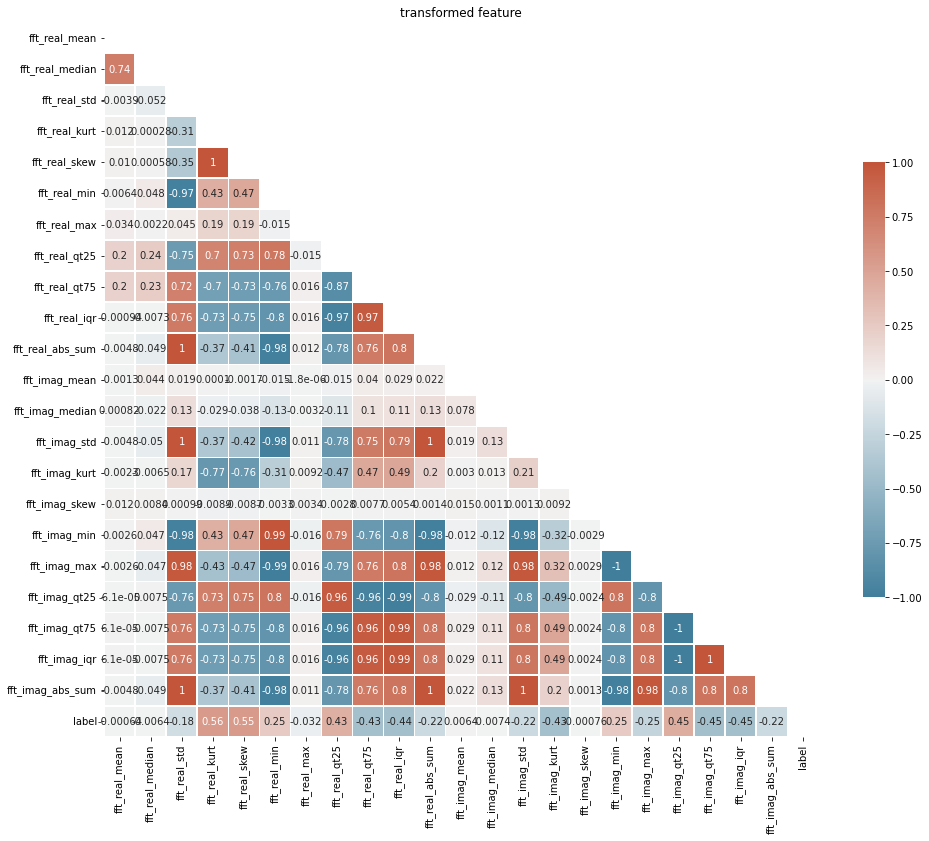

In [323]:
corr_lag = ffeatures_df.corr()
mask = np.triu(np.ones_like(corr_lag, dtype=bool))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(16, 16))
ax = sns.heatmap(corr_lag, mask=mask, cmap=cmap,  center=0,
                 square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
ax.set_title('transformed feature');

In [324]:
ffeatures_df.isnull().sum().sort_values(ascending = False)

fft_real_mean       0
fft_imag_median     0
fft_imag_abs_sum    0
fft_imag_iqr        0
fft_imag_qt75       0
fft_imag_qt25       0
fft_imag_max        0
fft_imag_min        0
fft_imag_skew       0
fft_imag_kurt       0
fft_imag_std        0
fft_imag_mean       0
fft_real_median     0
fft_real_abs_sum    0
fft_real_iqr        0
fft_real_qt75       0
fft_real_qt25       0
fft_real_max        0
fft_real_min        0
fft_real_skew       0
fft_real_kurt       0
fft_real_std        0
label               0
dtype: int64

### 2.7.3 Concat features in time and frequency domains

In [379]:
train_df = pd.concat([tfeatures_df,ffeatures_df], axis = 1)
train_df.head()

,ttf_avg,mean,median,std,kurt,skew,min,max,qt25,qt75,...,fft_imag_median,fft_imag_std,fft_imag_kurt,fft_imag_skew,fft_imag_min,fft_imag_max,fft_imag_qt25,fft_imag_qt75,fft_imag_iqr,fft_imag_abs_sum
0,1.45006776,4.88411333,5.0,5.10110613,33.66248129,-0.02406117,-98.0,104.0,3.0,7.0,...,2.84217094e-13,1399.85930152,25.64461938,2.84803652e-17,-23432.71943272,23432.71943272,-482.48988899,482.48988899,964.97977798,1.18823167e+08
1,1.43078184,4.74680000,5.0,6.17338350,116.79737733,0.52628358,-154.0,181.0,2.0,7.0,...,3.12638804e-13,1693.93451155,24.00093969,3.34863360e-18,-24701.00049572,24701.00049572,-496.77260985,496.77260985,993.54521971,1.34610296e+08
2,1.41123080,4.72576667,5.0,6.58882378,98.75851718,0.39056050,-154.0,181.0,2.0,7.0,...,3.97903932e-13,1810.31830029,27.79477711,-6.14526580e-17,-27236.18058607,27236.18058607,-498.11685336,498.11685336,996.23370671,1.39071612e+08
3,1.39201939,4.75300000,5.0,5.71503591,33.74477916,-0.10766378,-115.0,111.0,2.0,7.0,...,-2.84217094e-14,1564.79370010,29.76921836,-5.22506050e-17,-27162.57825514,27162.57825514,-489.98951377,489.98951377,979.97902755,1.26118692e+08
4,1.37191772,4.90639333,5.0,6.96739703,33.55521141,0.21739056,-106.0,140.0,2.0,7.0,...,1.70530257e-13,1921.22697967,28.32092741,3.94775230e-17,-30073.49706617,30073.49706617,-504.60618288,504.60618288,1009.21236576,1.44927723e+08


## 2.8 Pandas profiling for a training segment

In [ ]:
df_tr_sec = pd.read_pickle(pathlist[7])

In [ ]:
profile = ProfileReport(df_tr_sec, title="Pandas Profiling Report of the Training Data 6")

In [ ]:
# profile.to_widgets()

In [ ]:
profile.to_file("../report/training_data_report_6.html")

## 2.5.5 Resampling the training data with 1 ms sampling rate

In [ ]:
# power spectrum density (square of amplitude spectrum)
def psd(input_signal):
    f, Pxx_den = signal.periodogram(input_signal, fs = 1/1.1e-9)
    f_dom = f[np.argmax(Pxx_den)]
    return f, Pxx_den, f_dom

In [ ]:
def iqr(X):
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    iqr_X = Q3 - Q1
    return iqr_X

In [ ]:
def create_feature(X):
    mean_X = X.mean()
    median_X = X.median()
    std_X = X.std()
    iqr_X = iqr(X)
    range_X = np.max(X) - np.min(X)
#     min_X = np.min(X)
#     max_X = np.max(X)
#     f, Pxx_den, f_dom_X = psd(X)
    return [mean_X, median_X, std_X, iqr_X, range_X]

In [ ]:
def create_lag_feature(X, periods= 0):
    feature_list = []
    for period in range(1,periods):
        feature_list.extend(create_feature(X.diff(periods))) 
    return feature_list

In [ ]:
def create_feature_by_smplrt(df, precision):
    if precision == 4:
        col_name = 'ttf_ms'
    elif precision == 6:
        col_name = 'ttf_us'
        
    # Create feature using statistics
    df[col_name] = df['time_to_failure'].round(precision).astype('str')
    df_agg = df.groupby(col_name)['acoustic_data'].agg(create_feature)
    df_agg = pd.DataFrame(df_agg.tolist(), index= df_agg.index, columns = [ 'mean','median','std','iqr','range'])
    
    # prepare feature names of lagging data in time domain
    col_name_by_lag = [i + '_lag' for i in ['mean','median','std','iqr','range']]
    col_names = []
    for j in range(1,11):
        col_names.extend([name + '_'+ str(j) for name in col_name_by_lag])
        
    # Create feature using time lagging on acoustic data
    df_lag_agg = df.groupby(col_name)['acoustic_data'].agg(create_lag_feature, periods = 11)
    df_lag_agg = pd.DataFrame(df_lag_agg.tolist(), index= df_lag_agg.index, columns =col_names)
    
    # Merge features in time domains
    df_time = df_agg.merge(df_lag_agg, how = 'left',left_index = True, right_index = True)

    # Frequency domain statistics in sampling signal
    df_psd = df.groupby(col_name)['acoustic_data'].agg(psd)
    df_psd = pd.DataFrame(df_psd.tolist(), index= df_psd.index, columns = ['freq', 'psd','f_dom'])
    
    # prepare feature names in frequency domain
    fsecs = ['f_sec' + str(num) for num in range(1,11)] # variable names
    df_f = pd.DataFrame(columns = fsecs)
    for index, row in df_psd.iterrows():
        f_dict = dict()
        freq_sec = np.linspace(0,1e8,11)
        PSD = row['psd']
        freq = row['freq']
        area = PSD[freq < 1e8].sum()

        for idx, fsec in enumerate(fsecs):
            row_filter = (freq >= freq_sec[idx]) & (freq < freq_sec[idx+1])
            pzone = PSD[row_filter].sum()    
            f_dict[fsec] = pzone / area
        temp = pd.DataFrame(f_dict,index =[index] )
        df_f = df_f.append(temp) 
    df_psd = df_psd.merge(df_f, how = 'left', left_index = True, right_index = True)
    
    df_new_smplrt = df_time.merge(df_psd, how = 'left', left_index = True, right_index = True).reset_index()
    df_new_smplrt[col_name] = df_new_smplrt[col_name].astype('float')
    return df_new_smplrt

### 2.5.5.4 Frequency domain in 1 ms sampling signal

Plot periodogram (square of amplitude spectrum)

In [ ]:
row1 = df_tr_sec['ttf_round'] == df_tr_sec['ttf_round'].unique()[1]
f1, Pxx_den1, f_dom1 = psd(df_tr_sec.loc[row1,'acoustic_data'])

row2 = df_tr_sec['ttf_round'] == df_tr_sec['ttf_round'].unique()[2]
f2, Pxx_den2, f_dom2 = psd(df_tr_sec.loc[row2,'acoustic_data'])

fig, ax_list = plt.subplots(2,1,figsize=(16, 12), dpi=100 )
ax = ax_list[0]
ax.plot(f1,Pxx_den1)
ax.set_ylabel('Power spectral density')
ax.set_xlabel('Frequency (Hz)')
ax.set_title('time to failure: ' + df_tr_sec['ttf_round'].unique()[1] + ' sec' )

ax = ax_list[1]
ax.plot(f2,Pxx_den2)
ax.set_ylabel('Power spectral density')
ax.set_xlabel('Frequency (Hz)')
ax.set_title('time to failure: ' + df_tr_sec['ttf_round'].unique()[2] + ' sec' );

The frequency component mainly distribute in 1e8 Hz. Divide this frequency interval to 10 buckets, calculate the probability to create some features

In [ ]:
df_psd = df_tr_sec.groupby('ttf_round')['acoustic_data'].agg(psd)
df_psd = pd.DataFrame(df_psd.tolist(), index= df_psd.index, columns = ['freq', 'psd','f_dom'])
df_psd.head()

In [ ]:
fsecs = ['f_sec' + str(num) for num in range(1,11)] # variable names
df_f = pd.DataFrame(columns = fsecs)
for index, row in df_psd.iterrows():
#     print(type(row))
    f_dict = dict()
    freq_sec = np.linspace(0,1e8,11)
    PSD = row['psd']
    freq = row['freq']
    area = PSD[freq < 1e8].sum()

    for idx, fsec in enumerate(fsecs):
        row_filter = (freq >= freq_sec[idx]) & (freq < freq_sec[idx+1])
        pzone = PSD[row_filter].sum()    
        f_dict[fsec] = pzone / area
    temp = pd.DataFrame(f_dict,index =[index] )
#     print(temp)
    df_f = df_f.append(temp) 
df_psd = df_psd.merge(df_f, how = 'left', left_index = True, right_index = True)
df_psd.head().T

# 2.7 Save data

In [380]:
train_df.to_pickle('../data/train_df.pkl')

# 2.8 Summary

For the training data:
* The data has zero missing values for both columns
* The data has only two column ,`acoustic_data` in int type and `time_to_failure` in float type. `time_to_failure` is our target.
* The data has 629,145,480 records, too large to operate.
* `acoustic_data` is the acoustic emission signal (amplitude), consisting of many peaks and troughts. 
* `time_to_failure` decreases from a value to zero periodically. The data should be truncated based on it.
* 17 segments were obtained after analyzing chunk data in the rawdata. 
* Each training segment has different time length
* The first one only has about two seconds record to earthquake. The last one is not complete because the `time_to_failure` is 9.75 s, far from zero.
* After `acoustic_data` reaches a extremly large event, the eqrthquake occurs soon in each training segment, and `time_to_failure` is less than 0.5s.

For the testing data:
* Only one row in each file, which is the `acoustic_data`
* Each segment contains 150k records, a small segment from a complete earthquake event. By comparision, records in training data is about 200 times of the test data. This may inspire us the feature extraction from the training data
* Similar to the training data, the average `acoustic_data` of a test data are small, while some abnormal `acoustic_data` exists. These determines what a feature is.
* Most test data may not contain the extremly large event with an absolute of amplitude over 1000. They contains peaks at a scale of several hundred amplitude

7/11/2022
For the training data:

* Resampling using groupby on round precision = 4 for `time_to_failure`
* Time lagging is tried on `acoustic_data` to create features. However, what time step is an optimum value?